# Development platform for SPICE-based orbit propagator

2019/11/07

### Developed with problem for GTOC4 in mind:
- allow mutliple bodies to be propagated at the same time (e.g. multiple asteroids and spacecraft)
- compute relative distance between specified bodies during propagation)

In [1]:
import numpy as np
import spiceypy as spice
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import time

In [2]:
# load spice kernels
spice.furnsh('../spice/naif0012.tls')

# define gravitational parameters
MU = 1.32712440018*10**11      # sun's gravitational parameter [km^3/s^2]
au2km = 1.49597870691*10**8    # 1 astronomical unit [AU] to [km]
g0 = 9.80665                   # gravitational acceleration [m/s^2]


In [17]:
# import ephemerides data from GTOC4 into pandas dataframe
elmnts = ['Name','Epoch','a','e','i','LAN','periap','theta']
df = pd.read_fwf('../gtoc4_problem_data.txt', sep='\t', skiprows=1)   # FIXME
#print(df.tail(10))

# reassign column names
df.columns =  ['Name','Epoch','a','e','i','LAN','omega','M0']

# convert 'Name' from 'xxxx' to xxxx integers   FIXME!!!!
num,tmp = df.shape
for i in range(num):    
    dmp1 = df.at[i,'Name']
    #print(dmp1)
    dmp2 = dmp1[1:]
    #print(dmp2)
    df.at[i,'Name'] = dmp2[:len(dmp2)]
    #df.at[i,'Name'] = dmp2[:end]

print(df.shape)


(1436, 8)


In [19]:
# Earth ephemeris
def Earth(param):
    """Function returns ephemeris value prompted, as defined by GTOC4 problem statement
    Args:
        param (str): orbital parameter to be fetched
            a: semi-major axis [AU]
            e: eccentricity
            i: inclination [deg]
            LAN: longitude of ascendig node [deg]
            omega: argument of periapsis [deg]
            M0: mean anomaly [deg]
            t: Epoch at which these elements are defined [MJD]
    Returns:
        (float): value of prompted parameter
    """
    if param == 'a':
        retval = 0.999988049532578
    elif param == 'e':
        retval = 1.671681163160 / np.power(10,2)
    elif param == 'i':
        retval = 0.8854353079654 / np.power(10,3)
    elif param == 'LAN':
        retval = 175.40647696473
    elif param == 'omega':
        retval = 287.61577546182
    elif param == 'M0':
        retval = 257.60683707535
    elif param == 't':
        retval = 54000
    else:
        print('function parameter is invalid')
        return None
    return retval


In [ ]:
# function to convert orbital elements to state-vector
def sv2el():


In [ ]:
# Create spacecraft dataframe



In [4]:
# create smaller pandas dataframe to test propagator

# FIXME : merge with spacecraft dataframe!

#  df1.merge(df2, left_on='lkey', right_on='rkey')
el_pd1 = df[0:10]
el_pd1

,Name,Epoch,a,e,i,LAN,omega,M0
0,1580',54800.0,2.196803,0.487683,52.090794,62.324795,159.539839,3.521687
1,1620',54800.0,1.245551,0.335511,13.337693,337.266017,276.806539,136.950031
2,1943',54800.0,1.430317,0.255816,8.704065,246.401915,338.253875,288.405238
3,2061',54800.0,2.264953,0.537119,3.770822,207.654108,156.432028,46.995497
4,2135',54800.0,1.599572,0.503268,23.054312,191.262849,290.838892,256.724981
5,2201',54800.0,2.172222,0.712804,2.516765,76.619362,96.225760,353.116063
6,2329',54800.0,2.404555,0.657496,24.429960,169.439381,145.831977,235.825556
7,2340',54800.0,0.844211,0.449758,5.854788,211.504602,39.994196,240.448274
8,2368',54800.0,2.104871,0.413837,5.237069,287.592983,42.605367,87.284486
9,3199',54800.0,1.574485,0.283803,32.969572,340.043975,53.374897,65.458709


In [5]:
# conversion between MJD and JD
# (Data given in MJD, SPICE deals with JD)
def mjd2jd(mjd):
    """function converts MJD (Modified Julian Date) to JD (Julian Date)
    Args:
        mjd (float or lst): float or list of floats of ephemerides in MJD to be converted to JD
    Returns:
        (float or float): float or list of ephemeris equivalent in JD
    """
    if type(mjd) == list: 
        jd = [el + 2400000.5 for el in mjd]
    else:
        jd = mjd + 2400000.5
    return jd

def jd2mjd(jd):
    """function converts JD (Julian Date) to MJD (Modified Julian Date)
    Args:
        mjd (float or lst): float or list of floats of ephemerides in JD to be converted to MJD
    Returns:
        (float or float): float or list of ephemeris equivalent in MJD
    """
    if type(jd) == list: 
        mjd = [el - 2400000.5 for el in jd]
    else:
        mjd = jd - 2400000.5
    return mjd


In [10]:
def propagate_spice(etr_mjd, eldf, MU=1.32712440018*10**11, step=1000, sv_option=True, dr_option=True):
    """
    SPICE-powered orbit propagator developed for GTOC4
    Args:
        et_MJD (lst): list including start and end time of propagation (in MJD)
        step (float): steps of propagation
        eldf (pandas df): pandas dataframe of orbital elements to be propagated (expect spacecraft to be first row)
        sv_option (bool): if set to True, compute state-vector
        dr_option (bool): if set to True, compute relative position vector between object of first row and object of other rows
    
    Returns:
        (tuple): time-array [JD], state-vector (if True), relative position vector (if True), and relative position scalar
            time-array is a 1D list of Epoch [JD]
            
            state-vector is (#of body * step * 7) 3d numpy array
                (third column: x, y, z, vx, vy, vz, Epoch)
                
            relative position vector is (#of body * step * 4) 3d numpy array
                (third column: dx, dy, dz, Epoch)
                
            and relative position salar is (#of body * step * 2) 3d numpy array
                (third column: dr, Epoch)
                
    Examples:
        et, sv, dr, drnorm = propagate_spice(etr_MJD, el_pd1, MU=1.32712440018*10**11, step=steps, sv_option=True, dr_option=True)
    """
    
    # measure time at start of program
    tstart = time.time()
    
    # convert time range from MJD to JD
    etr_jd = mjd2jd((etr_mjd))
    # create time array
    etrsteps = [x * (etr_jd[1] - etr_jd[0])/step + etr_jd[0] for x in range(step)]
    # store number of bodies to propagate
    [bdy,tmp] = eldf.shape
    
    # FIXME - reattribute indices to inserted pandas df?
    
    
    # initialize 3d numpy array to store state-vectors and object name
    if sv_option == True:
        sv = np.zeros((bdy, step, 7))
        
    # initialise 3d numpy array to store relative position vector and object name
    if dr_option == True:
        dr = np.zeros((bdy-1, step, 4))
        drnorm = np.zeros((bdy-1, step, 2))
    
    # propagate over time array
    for i in range(step):
        # prepare orbital elements for spice.conics() function
        for j in range(bdy):
            # convert orbital elements to spice-format
            rp = eldf.at[j,'a']*au2km * (1 - eldf.at[j,'e'])
            elts = np.array([rp, eldf.at[j,'e'], np.rad2deg(eldf.at[j,'i']), np.rad2deg(eldf.at[j,'LAN']), np.rad2deg(eldf.at[j,'omega']), np.rad2deg(eldf.at[j,'M0']), mjd2jd(eldf.at[j,'Epoch']), MU])
            tmp = spice.conics(elts, etrsteps[i])
            
            # FIXME - store state-vector of one object
            if sv_option == True:
                for k in range(6):
                    sv[(j,i,k)] = tmp[k]
                sv[j,i,6] = etrsteps[i]
                    
            # store relative state-vector of current object (except if object is the spacecraft ifself)
            if dr_option == True:
                if j == 0:
                    sc_currentpos = np.zeros(3)
                    # store current spacecraft location
                    sc_currentpos[0] = tmp[0]  # state-vector[0]
                    sc_currentpos[1] = tmp[1]  # state-vector[1]
                    sc_currentpos[2] = tmp[2]  # state-vector[2]
                else:
                    # compute relative vector
                    for l in range(3):
                        dr[(j-1,i,l)] = tmp[l] - sc_currentpos[l]
                    dr[(j-1,i,3)] = etrsteps[i]
                    drnorm[(j-1,i,0)] = np.sqrt( dr[(j-1,i,0)]**2 + dr[(j-1,i,1)]**2 + dr[(j-1,i,2)]**2 )
                    drnorm[(j-1,i,1)] = etrsteps[i]
                    
    # measure time
    tend = time.time()
    # computation time
    dt = tend - tstart
    # print computational time
    print(f'Propagation time: {round(dt,2)} [sec]')
    
    if sv_option == True and dr_option == True:
        return etrsteps, sv, dr, drnorm
    elif sv_option == True and dr_option == False:
        return etrsteps, sv
    elif sv_option == False and dr_option == True:
        return etrsteps, dr, drnorm
    


In [11]:
# test run function with el_pd1
# propagation range time
etr_utc = ['Jan 1, 2015', 'Jun 30, 2025']  # currently working with 6 months ~ 182 days
etr_MJD = [spice.str2et(etr_utc[0]), spice.str2et(etr_utc[1])]
# set time-step in seconds
steps = 300
dt = (spice.str2et(etr_utc[1]) - spice.str2et(etr_utc[0]))/steps
dt_day = dt/(60*60*24)
print(f'Propagating with {steps} steps, time-interval of {dt_day:.4} [days]')

# call function to propagate
et, sv, dr, drnorm = propagate_spice(etr_MJD, el_pd1, MU=1.32712440018*10**11, step=steps, sv_option=True, dr_option=True)

sv[(0,2,0)]

Propagating with 300 steps, time-interval of 12.78 [days]
Propagation time: 0.31 [sec]


53797694.59379932

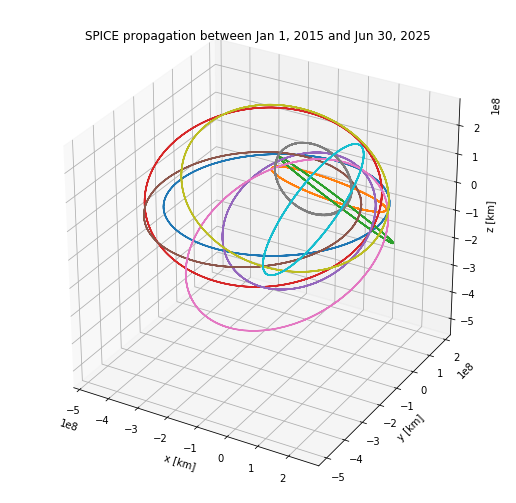

In [12]:
#%matplotlib

# plot propagated trajectories
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection = '3d')

# store number of bodies to propagate
[bdy,tmp] = el_pd1.shape
# store number of time steps
[tmp,steps,tmp] = sv.shape

# FIXME - ploting...? make a function?
for j in range(bdy):
    tmpx = []
    tmpy = []
    tmpz = []
    for i in range(steps):
        tmpx.append(sv[(j,i,0)])
        tmpy.append(sv[(j,i,1)])
        tmpz.append(sv[(j,i,2)])
    ax.plot(tmpx,tmpy,tmpz)

plt.title(f'SPICE propagation between {etr_utc[0]} and {etr_utc[1]}')
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_zlabel('z [km]')
plt.show()

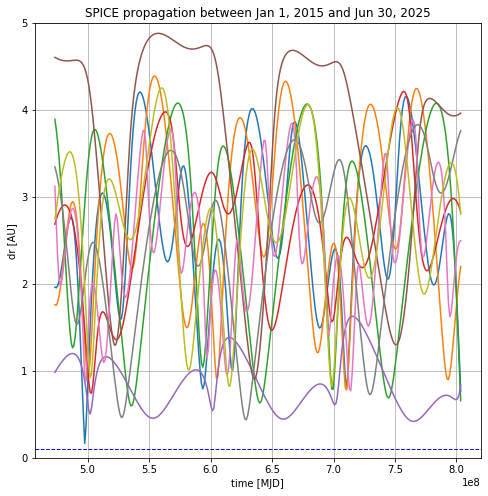

In [18]:
# plot computed relative distances of spacecraft to asteroids
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()

# convert time-axis
# https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/cspice/et2utc_c.html
et_utc = []
for i in range(len(et)):
    et_utc.append(spice.et2utc(et[i],"ISOC",-3))
    
# number of objects propagated (without spacecraft)
for j in range(bdy-1):
    drlst = []
    for i in range(steps):
        drlst.append(drnorm[j,i,0]/au2km)
    ax.plot(jd2mjd(et), drlst)
    
plt.title(f'SPICE propagation between {etr_utc[0]} and {etr_utc[1]}')

# plot threashold dr
plt.axhline(y=0.1, label='dr = 0.1 AU',ls='--',lw=1,c='b')

ax.set_xlabel('time [MJD]')
ax.set_ylabel('dr [AU]')
plt.ylim(0, 5)
plt.grid()
plt.show()

#print(et_utc)